In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import os

### Important: the following code consists of a mix of Python and R commands. We are currently migrating all code to Python. If you nevertheless want to run this legacy notebook, please open an issue to obtain the environment.yml file necessary to set up your virtual environment. 

To find your R home directory, open a terminal and type in:
```
R RHOME
```
If you created a conda environment from the environment.yml file we provided, you'll have to activate your environment first:
```
conda env create -f environment.yml
conda activate r_v4
R RHOME
```

In [2]:
os.environ["R_HOME"] = "/dss/dsshome1/06/di93vel/.conda/envs/r_v4/lib/R"  # change as needed

In [3]:
import anndata2ri
import rpy2
from rpy2.robjects import r


anndata2ri.activate()
# This loads the rpy2 package and enables the rmagic commands
%load_ext rpy2.ipython

## Install required R packages

In [4]:
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

<rpy2.rinterface_lib.sexp.NULLType object at 0x7f686cee0b90> [RTYPES.NILSXP]

In [5]:
# R package names
packnames = ('ggplot2', 'ggsci')

from rpy2.robjects.vectors import StrVector

# selectively install what needs to be installed
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

In [6]:
%%R
library(ggplot2)
library(ggsci)

## test if ggplot was loaded correctly

`geom_smooth()` using formula = 'y ~ x'


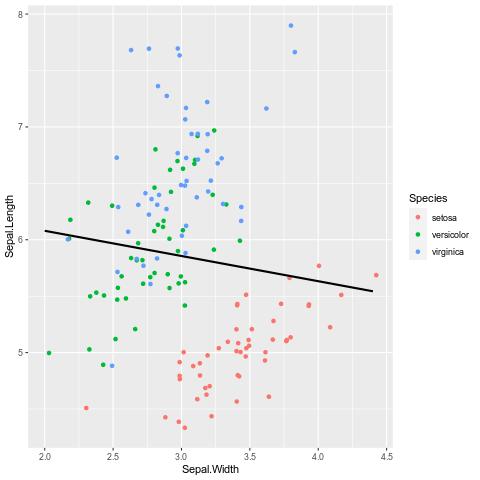

In [7]:
%%R
ggplot(iris, aes(y = Sepal.Length, x = Sepal.Width)) +
  geom_jitter(aes(col = Species)) +
  geom_smooth(method = "lm", se = FALSE, col = "black")

## Load data

In [8]:
WD = "/data/mibitof_breast_cancer"  # change as needed

In [9]:
adata = sc.read(os.path.join(WD, "mibitof_breast_phenotype_feature_matrices_zscore_Nenrichments_2.h5ad"))
adata

/dss/dsshome1/06/di93vel/.conda/envs/r_v4/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/dss/dsshome1/06/di93vel/.conda/envs/r_v4/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 69672 × 59
    obs: 'event', 'Point_Num', 'CohortNumber', 'Tissue_Type', 'Status', 'Tissue', 'sublineage', 'phenotype', 'compartment', 'celllineage', 'sublineage_code', 'phenotype_code', 'compartment_code', 'celllineage_code', 'manual_gating_cellineage', 'manual_gating_subineage', 'manual_gating_phenotype', 'innerduct_mask', 'distal_mask', 'stroma_mask', 'periph_mask', 'epi_mask', 'duct_mask', 'myoep_mask', 'ERstatus', 'HER2status', 'ARstatus', 'Ki67status', 'pS6status', 'GLUT1status', 'HIF1astatus', 'COX2status', 'CD36status', 'CD44status', 'PD1status', 'PDL1status', 'IDO1status', 'GZMBstatus', 'ECADstatus', 'MMP9status', 'VIMstatus', 'FAPstatus', 'HLADRstatus', 'CD3status', 'SMAstatus', 'COLIstatus', 'CK5status', 'CK7status', 'P63status', 'myoep_dist_label', 'myoep_dist_MinDist', 'myoep_dist_MaxDist', 'myoep_dist_MedDist', 'myoep_dist_MeanDist', 'celltype_code', 'myoep_dist_MinDist1', 'Neighbor_dist_TUMOR', 'Neighbor_dist_MYOEP', 'Neighbor_dist_FI

In [10]:
# before filtering: 79 subjects
pd.unique(adata.obs.batch.values)

['0', '1', '2', '3', '4', ..., '74', '75', '76', '77', '78']
Length: 79
Categories (79, object): ['0', '1', '2', '3', ..., '75', '76', '77', '78']

In [11]:
adata.obs.Status.value_counts()

ctrl      37684
case      12729
ipsinv    11792
normal     7467
Name: Status, dtype: int64

In [12]:
# filtering
adata = adata[adata.obs["Status"].isin(["case", "ctrl", "normal"])]

In [13]:
# after filtering: 67 subjects
pd.unique(adata.obs.batch.values)

['0', '1', '2', '3', '4', ..., '74', '75', '76', '77', '78']
Length: 67
Categories (67, object): ['0', '1', '2', '3', ..., '75', '76', '77', '78']

#### To generate "adata.uns['celltype_interaction']" and "adata.uns['neighborhood_composition']", run the "shz_mibitof_breast_cancer.ipynb" notebook.

In [14]:
adata.uns['celltype_interaction']

,APC_APC,APC_BCELL,APC_CAF,APC_CD4T,APC_CD8T,APC_DC,APC_ENDO,APC_FIBRO_VIMonly,APC_IMMUNEOTHER,APC_MACS,...,TUMOR_CK5_TUMOR_CK5,TUMOR_CK5_TUMOR_ECADCK,TUMOR_CK5_TUMOR_EMT,TUMOR_CK5_TUMOR_LUMINAL,TUMOR_ECADCK_TUMOR_ECADCK,TUMOR_ECADCK_TUMOR_EMT,TUMOR_ECADCK_TUMOR_LUMINAL,TUMOR_EMT_TUMOR_EMT,TUMOR_EMT_TUMOR_LUMINAL,TUMOR_LUMINAL_TUMOR_LUMINAL
0,-0.252646,-0.266207,4.106290,4.007559,0.865354,0.000000,1.964038,-0.652286,0.000000,-0.575549,...,-0.480192,0.510561,-0.621259,-0.899666,-1.318091,0.940154,-0.764992,-0.300444,-0.295845,2.058598
1,2.442178,0.882166,2.341118,-0.188850,-1.307334,0.000000,1.200766,-1.326858,-0.806004,-1.261871,...,-0.791063,2.968883,-0.580584,-0.220749,-0.643033,-1.088183,0.593765,-0.166581,1.324708,0.917013
10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.193525,-0.217072,-0.160128,-0.292876,...,5.590891,0.616937,-0.163383,-0.348235,5.006062,-0.207129,2.727826,0.000000,-0.208464,0.201981
11,-0.817048,0.000000,0.000000,0.000000,-0.531878,0.000000,-0.512575,3.073051,-1.053428,-0.304290,...,-0.228424,-0.855889,-0.424202,2.513383,-0.176759,1.887292,1.259407,-0.296976,-0.839240,0.621327
12,1.555593,-0.240192,-0.436968,-0.695358,0.905322,0.000000,-0.311656,0.363164,-1.144735,-0.348776,...,-0.083960,-0.645483,3.489547,-1.071855,7.650707,0.688001,1.942268,1.369053,0.893036,0.439677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,-0.565032,0.000000,-0.238919,2.594150,0.000000,-0.270114,-0.346786,1.240552,2.281252,0.871465,...,0.000000,1.844948,-0.735413,-0.070888,7.401843,3.215831,0.354046,0.112923,0.876779,0.000000
77,-0.595204,0.789765,0.761532,0.722478,0.692523,0.894054,0.647351,-0.043450,-0.754476,-0.202315,...,1.552340,-0.109828,-0.464639,-1.230711,-1.220524,-0.771895,1.611822,-0.958526,0.899761,1.375697
78,2.423646,0.176154,5.010385,2.088819,2.222009,2.751560,3.818849,1.712359,0.175387,2.910967,...,0.032630,-0.646336,0.438127,2.465337,-0.089803,-0.254526,0.288518,-0.163813,-0.732320,7.587140
8,1.301336,0.000000,-0.572530,5.140600,3.946483,-0.836396,0.199601,7.209128,-1.101945,-1.018551,...,0.000000,0.000000,0.000000,0.000000,-0.222271,-0.169725,-1.140811,0.000000,-0.532017,1.750711


In [15]:
adata.uns['neighborhood_composition']

,APC,BCELL,CAF,CD4T,CD8T,DC,ENDO,FIBRO_VIMonly,IMMUNEOTHER,MACS,...,MYOEP,MYOFIBRO,NEUT,NORMFIBRO,OTHER,TCELL,TUMOR_CK5,TUMOR_ECADCK,TUMOR_EMT,TUMOR_LUMINAL
labels_id,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,3
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2
10,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,2,0,2
11,0,0,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
13,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317,1,0,0,1,0,0,1,1,1,1,...,0,1,0,0,0,0,0,0,0,0
1321,0,0,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,4
1342,2,0,1,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Experiment design

In [16]:
group = adata.obs[['library_id','batch','Status']].copy()
group.drop_duplicates(inplace=True)
group.set_index('library_id', inplace=True)
group

,batch,Status
library_id,,
0,0,ctrl
1,1,ctrl
2,2,ctrl
3,3,ctrl
4,4,ctrl
...,...,...
74,74,case
75,75,case
76,76,case


In [17]:
status_map = {
    'ipsinv': 'ibc',
    'ctrl': 'dcis',
    'case': 'dcis',
    'normal': 'normal',
}

group["StatusMap"] = group.Status.copy().map(status_map).astype('category')
group

,batch,Status,StatusMap
library_id,,,
0,0,ctrl,dcis
1,1,ctrl,dcis
2,2,ctrl,dcis
3,3,ctrl,dcis
4,4,ctrl,dcis
...,...,...,...
74,74,case,dcis
75,75,case,dcis
76,76,case,dcis


In [18]:
print(group.batch.cat.categories)
print(group.Status.cat.categories)
print(group.StatusMap.cat.categories)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '48', '52', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72',
       '73', '74', '75', '76', '77', '78'],
      dtype='object')
Index(['case', 'ctrl', 'normal'], dtype='object')
Index(['dcis', 'normal'], dtype='object')


In [19]:
# condition = group.StatusMap
condition = group.Status
patient = group.batch

In [20]:
interaction_mat = adata.uns['celltype_interaction']
interaction_mat['condition'] = condition
interaction_mat['subject_id'] = patient

In [21]:
interaction_mat

,APC_APC,APC_BCELL,APC_CAF,APC_CD4T,APC_CD8T,APC_DC,APC_ENDO,APC_FIBRO_VIMonly,APC_IMMUNEOTHER,APC_MACS,...,TUMOR_CK5_TUMOR_EMT,TUMOR_CK5_TUMOR_LUMINAL,TUMOR_ECADCK_TUMOR_ECADCK,TUMOR_ECADCK_TUMOR_EMT,TUMOR_ECADCK_TUMOR_LUMINAL,TUMOR_EMT_TUMOR_EMT,TUMOR_EMT_TUMOR_LUMINAL,TUMOR_LUMINAL_TUMOR_LUMINAL,condition,subject_id
0,-0.252646,-0.266207,4.106290,4.007559,0.865354,0.000000,1.964038,-0.652286,0.000000,-0.575549,...,-0.621259,-0.899666,-1.318091,0.940154,-0.764992,-0.300444,-0.295845,2.058598,ctrl,0
1,2.442178,0.882166,2.341118,-0.188850,-1.307334,0.000000,1.200766,-1.326858,-0.806004,-1.261871,...,-0.580584,-0.220749,-0.643033,-1.088183,0.593765,-0.166581,1.324708,0.917013,ctrl,1
10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.193525,-0.217072,-0.160128,-0.292876,...,-0.163383,-0.348235,5.006062,-0.207129,2.727826,0.000000,-0.208464,0.201981,case,10
11,-0.817048,0.000000,0.000000,0.000000,-0.531878,0.000000,-0.512575,3.073051,-1.053428,-0.304290,...,-0.424202,2.513383,-0.176759,1.887292,1.259407,-0.296976,-0.839240,0.621327,ctrl,11
12,1.555593,-0.240192,-0.436968,-0.695358,0.905322,0.000000,-0.311656,0.363164,-1.144735,-0.348776,...,3.489547,-1.071855,7.650707,0.688001,1.942268,1.369053,0.893036,0.439677,case,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,-0.565032,0.000000,-0.238919,2.594150,0.000000,-0.270114,-0.346786,1.240552,2.281252,0.871465,...,-0.735413,-0.070888,7.401843,3.215831,0.354046,0.112923,0.876779,0.000000,case,76
77,-0.595204,0.789765,0.761532,0.722478,0.692523,0.894054,0.647351,-0.043450,-0.754476,-0.202315,...,-0.464639,-1.230711,-1.220524,-0.771895,1.611822,-0.958526,0.899761,1.375697,case,77
78,2.423646,0.176154,5.010385,2.088819,2.222009,2.751560,3.818849,1.712359,0.175387,2.910967,...,0.438127,2.465337,-0.089803,-0.254526,0.288518,-0.163813,-0.732320,7.587140,ctrl,78
8,1.301336,0.000000,-0.572530,5.140600,3.946483,-0.836396,0.199601,7.209128,-1.101945,-1.018551,...,0.000000,0.000000,-0.222271,-0.169725,-1.140811,0.000000,-0.532017,1.750711,normal,8


In [22]:
sum(interaction_mat.condition.isna())

12

In [23]:
interaction_mat = pd.melt(interaction_mat, id_vars = ['condition','subject_id'])
interaction_mat.shape

(21804, 4)

## R code

### prepare experiment

In [24]:
%%R -i condition
print(condition)

     0      1      2      3      4      5      6      7      8      9     10 
  ctrl   ctrl   ctrl   ctrl   ctrl   ctrl normal   case normal   ctrl   case 
    11     12     13     14     15     16     17     18     19     20     21 
  ctrl   case   ctrl normal   ctrl   ctrl   ctrl   ctrl   case normal   ctrl 
    22     23     24     25     26     27     28     29     30     31     32 
  ctrl   ctrl   ctrl   ctrl   ctrl   ctrl   case   ctrl   ctrl normal   ctrl 
    33     34     35     36     37     38     39     40     41     42     43 
  ctrl   ctrl   ctrl   ctrl   ctrl   ctrl   ctrl   ctrl   case   ctrl   ctrl 
    44     45     48     52     60     61     62     63     64     65     66 
  ctrl normal normal normal normal   ctrl   ctrl   ctrl   ctrl   case   ctrl 
    67     68     69     70     71     72     73     74     75     76     77 
  ctrl   ctrl   ctrl   ctrl   case   case   case   case   case   case   case 
    78 
  ctrl 
Levels: case ctrl normal


In [25]:
%%R
print(length(condition))

[1] 67


In [26]:
%%R -i interaction_mat
cell_type_interaction_mat = data.frame(interaction_mat)

In [27]:
%%R
head(cell_type_interaction_mat)

  condition subject_id variable      value
0      ctrl          0  APC_APC -0.2526456
1      ctrl          1  APC_APC  2.4421778
2      case         10  APC_APC  0.0000000
3      ctrl         11  APC_APC -0.8170484
4      case         12  APC_APC  1.5555928
5      ctrl         13  APC_APC  0.0000000


In [28]:
%%R
cell_type_interaction_mat$subject_id <- as.factor(cell_type_interaction_mat$subject_id)
cell_type_interaction_mat$condition <- as.factor(cell_type_interaction_mat$condition)
cell_type_interaction_mat$condition <- relevel(cell_type_interaction_mat$condition, ref = 'normal')
head(cell_type_interaction_mat)

  condition subject_id variable      value
0      ctrl          0  APC_APC -0.2526456
1      ctrl          1  APC_APC  2.4421778
2      case         10  APC_APC  0.0000000
3      ctrl         11  APC_APC -0.8170484
4      case         12  APC_APC  1.5555928
5      ctrl         13  APC_APC  0.0000000


In [29]:
%%R
class(cell_type_interaction_mat$variable)

[1] "character"


In [30]:
%%R
dim(cell_type_interaction_mat)

[1] 21804     4


### (generalized) linear model

In [31]:
%%R
model <- lm(value ~ subject_id + variable*condition, data=cell_type_interaction_mat)
# model <- glm(value ~ variable*condition, data=cell_type_interaction_mat, family=poisson)
# model <- glm(value ~ variable*condition, data=cell_type_interaction_mat, family=quasipoisson)

In [32]:
%%R
names(summary(model))

 [1] "call"          "terms"         "residuals"     "coefficients" 
 [5] "aliased"       "sigma"         "df"            "r.squared"    
 [9] "adj.r.squared" "fstatistic"    "cov.unscaled"  "na.action"    


In [33]:
%%R
summary(model)


Call:
lm(formula = value ~ subject_id + variable * condition, data = cell_type_interaction_mat)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.6747 -0.5732 -0.1160  0.2889 10.7705 

Coefficients: (2 not defined because of singularities)
                                                    Estimate Std. Error t value
(Intercept)                                        1.2356461  0.1957492   6.312
subject_id1                                        0.0057248  0.1028125   0.056
subject_id2                                        0.1645114  0.1028125   1.600
subject_id3                                        0.0082732  0.1028125   0.080
subject_id4                                       -0.0873798  0.1028125  -0.850
subject_id5                                       -0.0603513  0.1028125  -0.587
subject_id6                                       -1.2105012  0.4528745  -2.673
subject_id7                                        0.1171527  0.3839524   0.305
subject_id8                      

variableENDO_OTHER                                -0.4346593  0.5693498  -0.763
variableENDO_TCELL                                 0.0479296  0.5693498   0.084
variableENDO_TUMOR_CK5                            -0.1750849  0.5693498  -0.308
variableENDO_TUMOR_ECADCK                          0.2948320  0.5693498   0.518
variableENDO_TUMOR_EMT                            -0.4320329  0.5693498  -0.759
variableENDO_TUMOR_LUMINAL                        -0.4025103  0.5693498  -0.707
variableFIBRO_VIMonly_FIBRO_VIMonly                3.3577648  0.5693498   5.898
variableFIBRO_VIMonly_IMMUNEOTHER                  0.1958852  0.5693498   0.344
variableFIBRO_VIMonly_MACS                         0.0010880  0.5693498   0.002
variableFIBRO_VIMonly_MAST                         0.4633702  0.5693498   0.814
variableFIBRO_VIMonly_MONO                         0.3292478  0.5693498   0.578
variableFIBRO_VIMonly_MONODC                      -0.3898899  0.5693498  -0.685
variableFIBRO_VIMonly_MYOEP             

variableCAF_TCELL:conditioncase                   -1.1099406  0.7297584  -1.521
variableCAF_TUMOR_CK5:conditioncase               -0.7880170  0.7297584  -1.080
variableCAF_TUMOR_ECADCK:conditioncase            -2.0187084  0.7297584  -2.766
variableCAF_TUMOR_EMT:conditioncase               -1.5412880  0.7297584  -2.112
variableCAF_TUMOR_LUMINAL:conditioncase           -1.8565546  0.7297584  -2.544
variableCD4T_CD4T:conditioncase                   -1.6686254  0.7297584  -2.287
variableCD4T_CD8T:conditioncase                   -1.5913287  0.7297584  -2.181
variableCD4T_DC:conditioncase                     -1.5558120  0.7297584  -2.132
variableCD4T_ENDO:conditioncase                   -1.4350847  0.7297584  -1.967
variableCD4T_FIBRO_VIMonly:conditioncase          -1.4139205  0.7297584  -1.938
variableCD4T_IMMUNEOTHER:conditioncase            -1.0164406  0.7297584  -1.393
variableCD4T_MACS:conditioncase                   -0.1814012  0.7297584  -0.249
variableCD4T_MAST:conditioncase         

variableTCELL_TUMOR_LUMINAL:conditioncase         -1.0265159  0.7297584  -1.407
variableTUMOR_CK5_TUMOR_CK5:conditioncase         -0.4582341  0.7297584  -0.628
variableTUMOR_CK5_TUMOR_ECADCK:conditioncase      -1.4919822  0.7297584  -2.044
variableTUMOR_CK5_TUMOR_EMT:conditioncase         -1.0901296  0.7297584  -1.494
variableTUMOR_CK5_TUMOR_LUMINAL:conditioncase     -0.9645073  0.7297584  -1.322
variableTUMOR_ECADCK_TUMOR_ECADCK:conditioncase    0.7801176  0.7297584   1.069
variableTUMOR_ECADCK_TUMOR_EMT:conditioncase      -0.4783739  0.7297584  -0.656
variableTUMOR_ECADCK_TUMOR_LUMINAL:conditioncase  -1.2946102  0.7297584  -1.774
variableTUMOR_EMT_TUMOR_EMT:conditioncase         -1.5100141  0.7297584  -2.069
variableTUMOR_EMT_TUMOR_LUMINAL:conditioncase     -0.3249441  0.7297584  -0.445
variableTUMOR_LUMINAL_TUMOR_LUMINAL:conditioncase  1.4523906  0.7297584   1.990
variableAPC_BCELL:conditionctrl                   -1.0889969  0.6248716  -1.743
variableAPC_CAF:conditionctrl           

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 0.901138    
variableMONO_TUMOR_CK5                            0.996173    
variableMONO_TUMOR_ECADCK                         0.439164    
variableMONO_TUMOR_EMT                            0.550364    
variableMONO_TUMOR_LUMINAL                        0.931134    
variableMONODC_MONODC                             0.877254    
variableMONODC_MYOEP                              0.784937    
variableMONODC_MYOFIBRO                           0.688043    
variableMONODC_NEUT                               0.834933    
variableMONODC_NORMFIBRO                          0.791426    
variableMONODC_OTHER                              0.768046    
variableMONODC_TCELL                              0.855588    
variableMONODC_TUMOR_CK5                          0.991243    
variableMONODC_TUMOR_ECADCK                       0.684734    
variableMONODC_TUMOR_EMT                          0.722796    
variableMONODC_TUMOR_LUMINAL                      0.587101    
variableMYOEP_MYOEP                      

variableMAST_MYOEP:conditioncase                  0.606157    
variableMAST_MYOFIBRO:conditioncase               0.269007    
variableMAST_NEUT:conditioncase                   0.143375    
variableMAST_NORMFIBRO:conditioncase              0.173274    
variableMAST_OTHER:conditioncase                  0.419463    
variableMAST_TCELL:conditioncase                  0.000634 ***
variableMAST_TUMOR_CK5:conditioncase              0.052559 .  
variableMAST_TUMOR_ECADCK:conditioncase           0.082104 .  
variableMAST_TUMOR_EMT:conditioncase              0.013798 *  
variableMAST_TUMOR_LUMINAL:conditioncase          0.015252 *  
variableMONO_MONO:conditioncase                   0.096467 .  
variableMONO_MONODC:conditioncase                 0.221586    
variableMONO_MYOEP:conditioncase                  0.415673    
variableMONO_MYOFIBRO:conditioncase               0.013025 *  
variableMONO_NEUT:conditioncase                   0.013295 *  
variableMONO_NORMFIBRO:conditioncase              0.274

variableMACS_MONO:conditionctrl                   0.168868    
variableMACS_MONODC:conditionctrl                 0.027095 *  
variableMACS_MYOEP:conditionctrl                  0.087114 .  
variableMACS_MYOFIBRO:conditionctrl               0.025174 *  
variableMACS_NEUT:conditionctrl                   0.128030    
variableMACS_NORMFIBRO:conditionctrl              0.054010 .  
variableMACS_OTHER:conditionctrl                  0.011888 *  
variableMACS_TCELL:conditionctrl                  0.045900 *  
variableMACS_TUMOR_CK5:conditionctrl              0.083004 .  
variableMACS_TUMOR_ECADCK:conditionctrl           0.014190 *  
variableMACS_TUMOR_EMT:conditionctrl              0.005736 ** 
variableMACS_TUMOR_LUMINAL:conditionctrl          0.007025 ** 
variableMAST_MAST:conditionctrl                   0.004983 ** 
variableMAST_MONO:conditionctrl                   0.133936    
variableMAST_MONODC:conditionctrl                 0.175216    
variableMAST_MYOEP:conditionctrl                  0.144

In [34]:
%%R
print(table(coef(summary(model))[,4] < 0.05))


FALSE  TRUE 
  645   247 


In [35]:
%%R
print(summary(coef(summary(model))[,4]))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.04413 0.17575 0.32896 0.62988 0.99863 


### inspect significant coefficients

In [36]:
%%R
print(rownames(coef(summary(model))[coef(summary(model))[,4] < 0.01,]))

 [1] "(Intercept)"                                      
 [2] "subject_id6"                                      
 [3] "subject_id8"                                      
 [4] "subject_id14"                                     
 [5] "subject_id20"                                     
 [6] "subject_id31"                                     
 [7] "subject_id42"                                     
 [8] "subject_id45"                                     
 [9] "subject_id48"                                     
[10] "subject_id52"                                     
[11] "subject_id60"                                     
[12] "variableAPC_FIBRO_VIMonly"                        
[13] "variableCD8T_FIBRO_VIMonly"                       
[14] "variableENDO_FIBRO_VIMonly"                       
[15] "variableFIBRO_VIMonly_FIBRO_VIMonly"              
[16] "variableFIBRO_VIMonly_MYOEP"                      
[17] "variableFIBRO_VIMonly_TUMOR_LUMINAL"              
[18] "variableAPC_TUMOR_ECADCK:

In [37]:
%%R
signif_coefs = coef(summary(model))[coef(summary(model))[,4] < 0.01, ]
ggdat = data.frame('coef_label' = rownames(signif_coefs),
                   'pvals' = coef(summary(model))[coef(summary(model))[,4] < 0.01, 4])

head(ggdat)

               coef_label        pvals
(Intercept)   (Intercept) 2.813218e-10
subject_id6   subject_id6 7.526157e-03
subject_id8   subject_id8 5.369153e-03
subject_id14 subject_id14 6.226301e-03
subject_id20 subject_id20 5.939695e-03
subject_id31 subject_id31 4.728674e-03


In [38]:
%%R
ggdat <- ggdat[grep('condition', rownames(ggdat)), ]
ggdat

                                                                                         coef_label
variableAPC_TUMOR_ECADCK:conditioncase                       variableAPC_TUMOR_ECADCK:conditioncase
variableAPC_TUMOR_LUMINAL:conditioncase                     variableAPC_TUMOR_LUMINAL:conditioncase
variableBCELL_ENDO:conditioncase                                   variableBCELL_ENDO:conditioncase
variableCAF_TUMOR_ECADCK:conditioncase                       variableCAF_TUMOR_ECADCK:conditioncase
variableCD4T_TUMOR_ECADCK:conditioncase                     variableCD4T_TUMOR_ECADCK:conditioncase
variableCD8T_CD8T:conditioncase                                     variableCD8T_CD8T:conditioncase
variableCD8T_FIBRO_VIMonly:conditioncase                   variableCD8T_FIBRO_VIMonly:conditioncase
variableENDO_TUMOR_ECADCK:conditioncase                     variableENDO_TUMOR_ECADCK:conditioncase
variableENDO_TUMOR_LUMINAL:conditioncase                   variableENDO_TUMOR_LUMINAL:conditioncase


In [39]:
%%R
ggdat$condition = gsub('.*:(condition.*)','\\1', ggdat$coef_label)
ggdat$coef_label <- gsub('variable','',ggdat$coef_label)
ggdat$coef_label <- gsub(':condition.*', '', ggdat$coef_label)
ggdat

                                                                   coef_label
variableAPC_TUMOR_ECADCK:conditioncase                       APC_TUMOR_ECADCK
variableAPC_TUMOR_LUMINAL:conditioncase                     APC_TUMOR_LUMINAL
variableBCELL_ENDO:conditioncase                                   BCELL_ENDO
variableCAF_TUMOR_ECADCK:conditioncase                       CAF_TUMOR_ECADCK
variableCD4T_TUMOR_ECADCK:conditioncase                     CD4T_TUMOR_ECADCK
variableCD8T_CD8T:conditioncase                                     CD8T_CD8T
variableCD8T_FIBRO_VIMonly:conditioncase                   CD8T_FIBRO_VIMonly
variableENDO_TUMOR_ECADCK:conditioncase                     ENDO_TUMOR_ECADCK
variableENDO_TUMOR_LUMINAL:conditioncase                   ENDO_TUMOR_LUMINAL
variableFIBRO_VIMonly_FIBRO_VIMonly:conditioncase FIBRO_VIMonly_FIBRO_VIMonly
variableFIBRO_VIMonly_TUMOR_ECADCK:conditioncase   FIBRO_VIMonly_TUMOR_ECADCK
variableFIBRO_VIMonly_TUMOR_LUMINAL:conditioncase FIBRO_VIMonly_

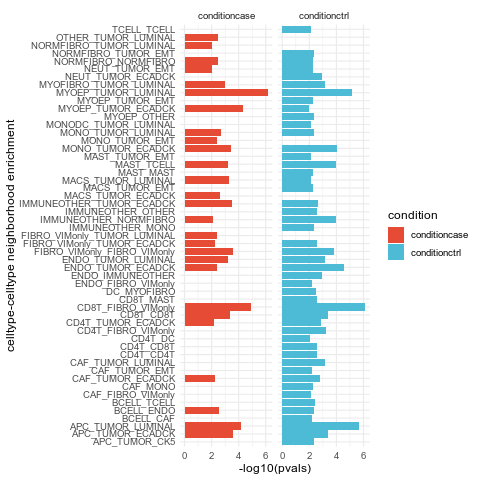

In [40]:
%%R
(p <- ggplot(ggdat, aes(x=coef_label, y = -log10(pvals), fill = condition)) +
 geom_bar(stat='identity', position = 'dodge') +
 coord_flip() +
 # theme(aspect.ratio = 4) +
 theme_minimal(base_size = 12) +
 facet_grid(.~condition) +
 scale_fill_npg() +
 xlab('celltype-celltype neighborhood enrichment')
)

In [41]:
%%R
ggsave("myplot.pdf", width=8, height=8, plot=p, dpi=300)